# 2. Améliorations -  Le système solaire n'est pas parfaitement un plan :

## 2.1 Prise en compte de la dimension Z:

Dans la première partie de ce rapport, on a utilisé le schéma de Verlet afin de simuler le système solaire en 2D, mais, il faut mentionner le fait que les planètes de système solaire ne sont pas parfaitement dans le plan de l'écliptique, il faudra alors ajouter la composante $Z$ aux paramètres de mouvements pour que la trajectoire de la sonde soit précise, d'où les modifications suivantes:

Ps: les nouvelles modifications seront dans le dossier en **In_3dim**

Il faut modifier la classe **objet** et les **fonctions auxiliaires**  :


In [1]:
import numpy as np
import matplotlib.pyplot as plt

class objet:
	""" Classe représentant les objets qui influence par la gravitation
		Attributs:
		nom 
		masse: Kg
		position (x, y, z): au
		vitesse (v_x, v_y, v_z) : au/day
	"""

	nom = "objet"
	masse = None
	x0 = 0
	y0 = 0
	z0 = 0
	vx0 = 0
	vy0 = 0
	vz0 = 0
	#Listes des positions et vitesse 
	x = None 
	y = None
	z = None
	vx = None
	vy = None 
	vz = None

	def __init__(self, nom = "objet", masse = None, x0 = 0, y0 = 0, z0 = 0, vx0 = 0, vy0 = 0, vz0 = 0):
		"""Constructeur de notre classe"""
		self.nom = nom
		self.masse = masse
		self.x0 = x0
		self.y0 = y0
		self.z0 = z0
		self.vx0 = vx0
		self.vy0 = vy0
		self.vz0 = vz0

**Variables Globales:**

In [2]:
au = 1.49597870e11 #Unité astronomique
jour = 24*3600 #Un jour

G = 6.67408e-11 #Constante gravitationelle 

**Modification des fonctions auxiliares :**

In [3]:
#Definition de fonction fx(M,x,y,z) et fy(M,x,y,z)
def fx(M,x,y,z):
	"""
	Retourne l'acceleration gravitationnelle suivant x dû à un objet de masse M distants de l'objet étudié de x**2+y**2+z**2
	"""
	return -((G*M)/(x**2+y**2+z**2)**(3/2))*x*(jour**2/au**3)

def fy(M,x,y,z):
	"""
	Retourne l'acceleration gravitationnelle suivant y dû à un objet de masse M distants de l'objet étudié de x**2+y**2+z**2
	"""
	return -((G*M)/(x**2+y**2+z**2)**(3/2))*y*(jour**2/au**3)

def fz(M,x,y,z):
	"""
	Retourne l'acceleration gravitationnelle suivant z dû à un objet de masse M distants de l'objet étudié de x**2+y**2+z**2
	"""
	return -((G*M)/(x**2+y**2+z**2)**(3/2))*z*(jour**2/au**3)

def E(M, x, y, z, vx, vy, vz):
	"""
	Calculer l'energie massique d'un objet sous effet d'un seul objet de masse M
	"""
	return 0.5*(vx**2+vy**2+vz**2)*(au**2/jour**2)-(G*M)/(np.sqrt(x**2+y**2+z**2)*au)
E = np.vectorize(E) #Vectoriser une fonction est benefique en terme de performance et memoire

def pot(M, x, y, z):
	"""
	Retourne le potentiel massique d'un objet par rapport à un autre objet de masse M et distant de x**2+y**2+z**2
	"""
	return -(G*M)/(np.sqrt(x**2+y**2+z**2)*au)

pot = np.vectorize(pot)

Comme c'est fait dans la partie précédente, on va aussi généraliser les fonctions **acceleration** et **Energy** en 3D.

In [4]:
def acceleration(bodies, i, j):
	"""
	Calculer l'acceleration relative à un objet bodies[i]
	bodies: tous les objets
	i: index of concerned body which undergoes the gravitation of other objects.
	j: index of the step
	"""
	N = len(bodies)

	ax = 0; ay = 0; az = 0 #L'acceleration

	for ip in range(N):
		#Chaque objet bodies[ip] applique une force de gravitation sur l'objet bodies[i] 

		if ip == i: #On veut que pas avoir le même objet bodies[ip]
			continue

		ax += fx(bodies[ip].masse, bodies[i].x[j]-bodies[ip].x[j], bodies[i].y[j]-bodies[ip].y[j], bodies[i].z[j]-bodies[ip].z[j])
		ay += fy(bodies[ip].masse, bodies[i].x[j]-bodies[ip].x[j], bodies[i].y[j]-bodies[ip].y[j], bodies[i].z[j]-bodies[ip].z[j])
		az += fz(bodies[ip].masse, bodies[i].x[j]-bodies[ip].x[j], bodies[i].y[j]-bodies[ip].y[j], bodies[i].z[j]-bodies[ip].z[j])

	return (ax, ay, az)

def Energy(bodies, i):
	"""
	L'Energie massique d'un objet sous l'effet d'autres objet qui lui entoure.
	"""
	N = len(bodies)
	potential = 0

	for ip in range(N):
		if ip == i:
			continue
		potential += pot(bodies[ip].masse, bodies[i].x-bodies[ip].x, bodies[i].y-bodies[ip].y, bodies[i].z-bodies[ip].z)
        
	return 0.5*(au**2/jour**2)*(bodies[i].vx**2+bodies[i].vy**2+bodies[i].vz**2)+potential

**Il faut aussi modifier le fichier des conditions initiales :**

NB: On prend les mêmes conditions initiales qu'auparavant mais en ajoutant les informations $Z$ et $V_z$.

In [5]:
import os
os.chdir("/home/mh541/Desktop/Projet_Numerique/In_3dim") #Please change to the directory where 'initial_conditions_solarsystem.txt' is saved

data = np.genfromtxt("initial_conditions_solarsystem.txt", usecols=(1,2,3,4,5,6,7), skip_header=1) #On ne peut pas importer du texte avec genfromtxt à cause de problème d'encodage
names = np.loadtxt("names_solarsystem.txt", dtype = str, skiprows=1, usecols=(1,)) #Importation de texte (nomes des objets dans le systeme solaire)

**Il aussi rénitialiser les données :**


In [6]:
bodies = np.array([objet() for i in range(10)])  #Creation d'une liste des objets (on a au total 9 objets: soleil et 9 planetes)

Nbr_obj = len(bodies) #Definition de nombres d'objets

#Definition des parametres de chaque objet
for i in range(Nbr_obj):
	bodies[i].nom = names[i][2:-1] # [2:-1] pour supprimer les caracteres indesires
	bodies[i].masse = data[i][0]
	bodies[i].x0 = data[i][1]
	bodies[i].y0 = data[i][2]
	bodies[i].z0 = data[i][3] 
	bodies[i].vx0 = data[i][4]
	bodies[i].vy0 = data[i][5]
	bodies[i].vz0 = data[i][6]

## 2.2 Implémentation de trajectoires des planètes de système solaire:

Maintenant, comme on a adapté ce qui est fait dans la partie 1 au cas général, on peut implémenter les trajectoires des planètes de la même manière que la partie 1 avec le schéma de Verlet.

PS: On fait l'hypothèse que le soleil reste fixe.

In [7]:
#Definition de pas de temps
dt = 1 #step
T = int(365/dt)*10 # (Nombre de steps)<-> Periode d'integration T = int(365/dt)* nbr ans

#Intialisation des attributs x,y,z,vx,vy,vz de chaque objet bodies[i]
for i in range(Nbr_obj):
	bodies[i].x = np.zeros(T); bodies[i].x[0] = bodies[i].x0
	bodies[i].y = np.zeros(T); bodies[i].y[0] = bodies[i].y0
	bodies[i].z = np.zeros(T); bodies[i].z[0] = bodies[i].z0

	bodies[i].vx = np.zeros(T); bodies[i].vx[0] = bodies[i].vx0
	bodies[i].vy = np.zeros(T); bodies[i].vy[0] = bodies[i].vy0
	bodies[i].vz = np.zeros(T); bodies[i].vz[0] = bodies[i].vz0

#Definitions des v_demi.
vx_demi = np.zeros(Nbr_obj)
vy_demi = np.zeros(Nbr_obj)
vz_demi = np.zeros(Nbr_obj)

#Implementation de l'integrateur de Verlet pour chaque objet (sauf le soleil)
for j in range(T-1): 

    #Phase 1: Calcul de vitesses milieu et affectation des position a l'intant j+1
	for i in range(1,Nbr_obj): #Modification des parametres pour chaque objet a l' instant j

		#Récupération de l'acceleration
		fx_j, fy_j, fz_j = acceleration(bodies, i, j) #L'acceleration au pas j relative à l'objet i

		#Definition des variables de milieux
		vx_demi[i] = bodies[i].vx[j] + (dt/2)*fx_j
		vy_demi[i] = bodies[i].vy[j] + (dt/2)*fy_j
		vz_demi[i] = bodies[i].vz[j] + (dt/2)*fz_j

		# Affectation des positions à l'indice i+1
		bodies[i].x[j+1] = bodies[i].x[j] + dt*vx_demi[i]
		bodies[i].y[j+1] = bodies[i].y[j] + dt*vy_demi[i]
		bodies[i].z[j+1] = bodies[i].z[j] + dt*vz_demi[i]

    #Phase 2: Affectation des vitesse a l'instant j+1   
	for i in range(1,Nbr_obj):

		#L'acceleration au pas i+1 relative à l'objet j
		fx_jplus1, fy_jplus1, fz_jplus1 = acceleration(bodies, i, j+1) #Il faut faire cette étape après le calcul de postion à l'indice i+1

        # Affectation des vitesses à l'indice j+1
		bodies[i].vx[j+1] = vx_demi[i] + (dt/2)*fx_jplus1
		bodies[i].vy[j+1] = vy_demi[i] + (dt/2)*fy_jplus1
		bodies[i].vz[j+1] = vz_demi[i] + (dt/2)*fz_jplus1

#[End]----------------------------------------------------------------------------------------------------


**Plot des trajectoires :**

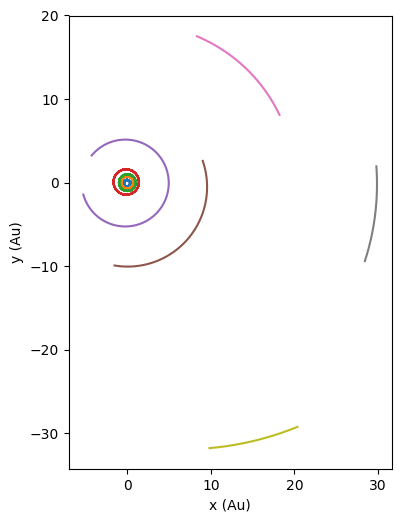

In [8]:
#Definition de figure
fig=plt.figure(figsize=(9, 6), dpi= 100, facecolor='w', edgecolor='k') #To modify the size of the figure
ax = fig.add_subplot(111) #definition de l'axe

for i in range(1,Nbr_obj):
	plt.plot(bodies[i].x, bodies[i].y)

plt.xlabel("x (Au)")
plt.ylabel("y (Au)")
    
plt.gca().set_aspect('equal', adjustable='box') #equal ratios of x and y

plt.show()

**Estimation précision en regardant l'énergie mécanique:**

Résultats : 
Energie moyenne = -1.00027285436, Ecart_Type = 0.000446119672785


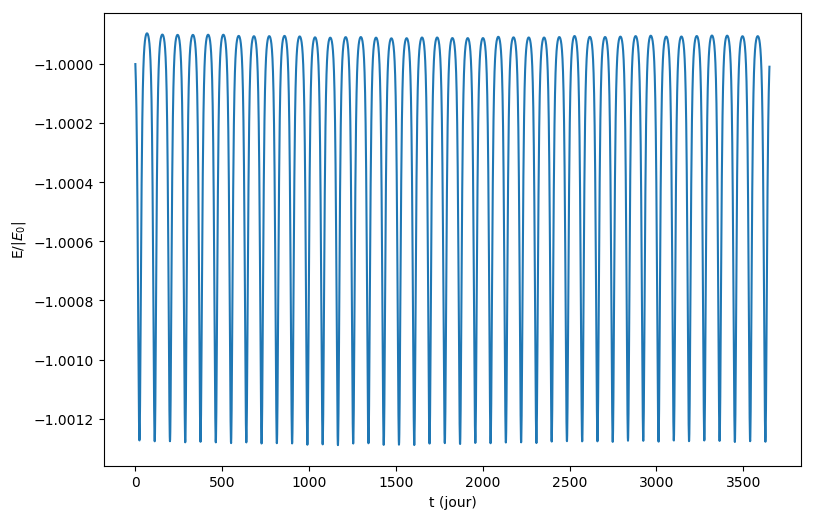

In [9]:
#Definition de figure
fig=plt.figure(figsize=(9, 6), dpi= 100, facecolor='w', edgecolor='k') #To modify the size of the figure
ax = fig.add_subplot(111) #definition de l'axe

Nrg = Energy(bodies, 1) #Cacul de l'energie d'un objet -> Changez le numero pour voir l'energie de chaque objet;
Nrg /= np.abs(Nrg[0])  #Pour Normaliser

#Plot de l'energie
t = np.linspace(1,T,T)*dt
ax.plot(t, Nrg)
# ax.plot(t[:365], Nrg[:365])

ax.set_xlabel("t (jour)")
ax.set_ylabel("E/$|E_0|$")

ax.get_yaxis().get_major_formatter().set_useOffset(False) #Disable scaling of values in plot wrt y-axis

#Affichage des résulats
print("Résultats : ")
print("Energie moyenne = " + str(np.mean(Nrg)) + ", Ecart_Type = " + str(np.std(Nrg)))

plt.show()

On remarque ici qu'on obtient une précision similaire à celle de l'approche en 2 dimensions, pour encore avoir de précision, il suffit juste de raffiner le pas d'intégration.

# 3- Comparaison avec des trajectoires non couplées:

Pour savoir s'il est nécessaire d'inclure les effets des autres planètes, on va comparer les trajectoires obtenues précédement avec celles de 9 planètes supposées indépendantes: c-à-d, on considère seulement la gravitation de soleil sur chaque planète. 

Dans le cas des trajectoires non couplées, on va considèrer la fonction **acceleration_sol** qui permet de calculer l'accéleration gravitationnelle dû au soleil sur chaque objet et aussi **Energy_sol** qui calcule l'énergie mécanique totale d'une planète sous effet de soleil seulement.

In [10]:
def acceleration_sol(bodies, i, j): #avec effet de soleil seulement
	"""
	Calculer l'acceleration relative à un objet bodies[i]
	bodies: tous les objets
	i: indice de l'objet concerne qui subit la gravitation du soleil seulement
	j: indice de pas
	"""

	ax = fx(bodies[0].masse, bodies[i].x[j], bodies[i].y[j], bodies[i].z[j])
	ay = fy(bodies[0].masse, bodies[i].x[j], bodies[i].y[j], bodies[i].z[j])
	az = fz(bodies[0].masse, bodies[i].x[j], bodies[i].y[j], bodies[i].z[j])

	return (ax, ay, az)

def Energy_sol(bodies,i):
	"""
	L'Energie massique d'un objet sous l'effet de soleil seulement.
	"""
	potential = pot(bodies[0].masse, bodies[i].x, bodies[i].y, bodies[i].z)

	return 0.5*(au**2/jour**2)*(bodies[i].vx**2+bodies[i].vy**2+bodies[i].vz**2)+potential

Maintenant, on a tout ce qu'il faut pour effectuer la comparaison entre les trajectoires couplées et non couplées. On a déja fait une implémentation des trajectoires couplées en haut, il suffit de sauvegarder les résultats obtenues afin de pouvoir rénitialiser les attributs de ** bodies ** et implémenter les trajectoires non couplées.

La manière la plus simple de sauvegarder ces données, c'est d'affecter le tableau d'objets **bodies** à un nouveau tableau **bodies_**

In [11]:
bodies_ = np.array([objet() for i in range(10)])

import copy
bodies_ = copy.deepcopy(bodies) #clonage de bodies sans faire attribuer la meme addresse a bodies_

**Implémentation des trajectoires non couplées :**

In [12]:
#----------------------------------------------------------------------------------------------------------
# Simuler les trajectoires à l'aide de Verlet sans couplage
#-------------------------

#Definition de pas de temps
dt = 1 #step
T = int(365/dt)*10 # (Nombre de steps)<-> Periode d'integration

#Definition des tableaux
for i in range(Nbr_obj):
	bodies[i].x = np.zeros(T); bodies[i].x[0] = bodies[i].x0
	bodies[i].y = np.zeros(T); bodies[i].y[0] = bodies[i].y0
	bodies[i].z = np.zeros(T); bodies[i].z[0] = bodies[i].z0


	bodies[i].vx = np.zeros(T); bodies[i].vx[0] = bodies[i].vx0
	bodies[i].vy = np.zeros(T); bodies[i].vy[0] = bodies[i].vy0
	bodies[i].vz = np.zeros(T); bodies[i].vz[0] = bodies[i].vz0

#Def des v_demi pour chaque objet
vx_demi = np.zeros(Nbr_obj)
vy_demi = np.zeros(Nbr_obj)
vz_demi = np.zeros(Nbr_obj)

#Implementation de l'integrateur de Verlet pour chaque objet (sauf le soleil)
for j in range(T-1): 
    #Phase 1: Calcul de vitesses milieu et affectation des position a l'intant j+1
	for i in range(1,Nbr_obj): #Modification des parametres pour chaque objet a un instant donne

		#Récupération de l'acceleration sous l'effet de soleil seulement
		fx_j, fy_j, fz_j = acceleration_sol(bodies, i, j) #L'acceleration au pas j relative à l'objet i
	
		#Definition des variables de milieux
		vx_demi[i] = bodies[i].vx[j] + (dt/2)*fx_j
		vy_demi[i] = bodies[i].vy[j] + (dt/2)*fy_j
		vz_demi[i] = bodies[i].vz[j] + (dt/2)*fz_j

		# Affectation des positions à l'indice i+1
		bodies[i].x[j+1] = bodies[i].x[j] + dt*vx_demi[i]
		bodies[i].y[j+1] = bodies[i].y[j] + dt*vy_demi[i]
		bodies[i].z[j+1] = bodies[i].z[j] + dt*vz_demi[i]

    #Phase 2: Affectation des vitesse a l'instant j+1   
	for i in range(1,Nbr_obj):

		#L'acceleration au pas i+1 relative à l'objet j
		fx_jplus1, fy_jplus1, fz_jplus1 = acceleration_sol(bodies, i, j+1) #Il faut faire cette étape après le calcul de postion à l'indice i+1

		bodies[i].vx[j+1] = vx_demi[i] + (dt/2)*fx_jplus1
		bodies[i].vy[j+1] = vy_demi[i] + (dt/2)*fy_jplus1
		bodies[i].vz[j+1] = vz_demi[i] + (dt/2)*fz_jplus1

#[End]----------------------------------------------------------------------------------------------------


**Plot d'énergie mécanique des deux cas (sans couplage et avec couplage) :**

Résultats : 
Energie moyenne = -1.00028092693, Ecart_Type = 0.000446681106274


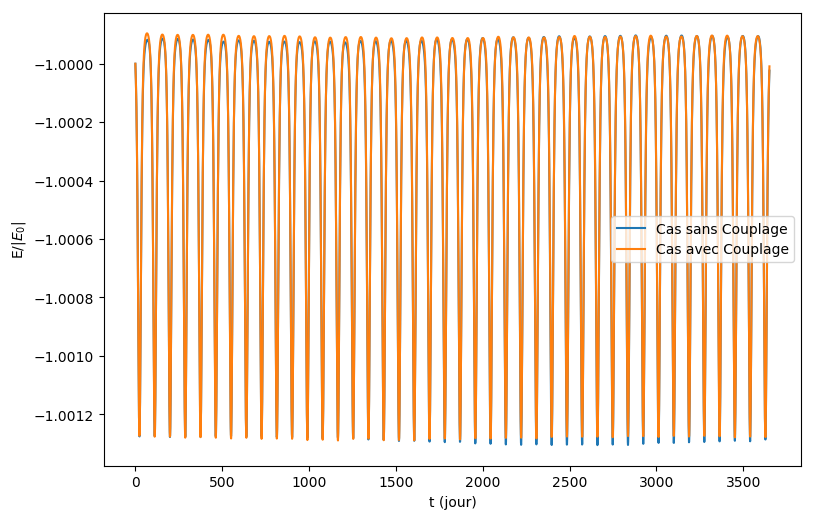

In [13]:
#----------------------------------------------------------------------------------------------------------
# Plot de l'energie, cas: avec couplage et sans couplage
#-------------------------
#Definition de figure
fig=plt.figure(figsize=(9, 6), dpi= 100, facecolor='w', edgecolor='k') #To modify the size of the figure
ax = fig.add_subplot(111) #definition de l'axe

#Calcul de l'energie
    #Cas sans couplage
Nrg = Energy(bodies, 1) #Calcul de l'energie d'un objet -> Changez le numero pour voir l'energie de chaque objet;
Nrg /= np.abs(Nrg[0])  #Pour Normaliser

 #Cas avec couplage
Nrg_ = Energy(bodies_, 1) #Cacul de l'energie d'un objet -> Changez le numero pour voir l'energie de chaque objet;
Nrg_ /= np.abs(Nrg_[0])  #Pour Normaliser


#Plot de l'energie
t = np.linspace(1,T,T)*dt
ax.plot(t, Nrg, label= "Cas sans Couplage")
ax.plot(t, Nrg_, label= "Cas avec Couplage")

ax.set_xlabel("t (jour)")
ax.set_ylabel("E/$|E_0|$")

ax.get_yaxis().get_major_formatter().set_useOffset(False) #Disable scaling of values in plot wrt y-axis

#Affichage des résulats
print("Résultats : ")
print("Energie moyenne = " + str(np.mean(Nrg)) + ", Ecart_Type = " + str(np.std(Nrg)))

plt.legend()
plt.show()

En termes d'énergie, on ne voit pas une différence significative entre les énergies de chaque objet dans le cas de couplage ou sans couplage, et les deux énergies ne se dévient pas trop de la valeur initial $E_0$, alors à priori pour vérifier s'il y a une différence entres les trajectoires obtenues, on va comparer les trajectoires des deux approches aux trajectoires réelles obtenues par observations astrométriques. 

## 2.3 Comparaison avec Trajectoires Réelles:

Dans cette partie, on va comparer les trajectoires réelles, couplées et non couplées, en prenant toujours comme date initiale la date prise dans la partie 1 de ce rapport: "2017-02-28" à "00:00 GMT". On fera la comparaison pour Venus, Terre et Jupyter.

PS: les trajectoires réelles sont prises ici: http://vo.imcce.fr/webservices/miriade/?forms

### 2.3.1 Venus:

**Plot des trajectoires suivant x et y:**

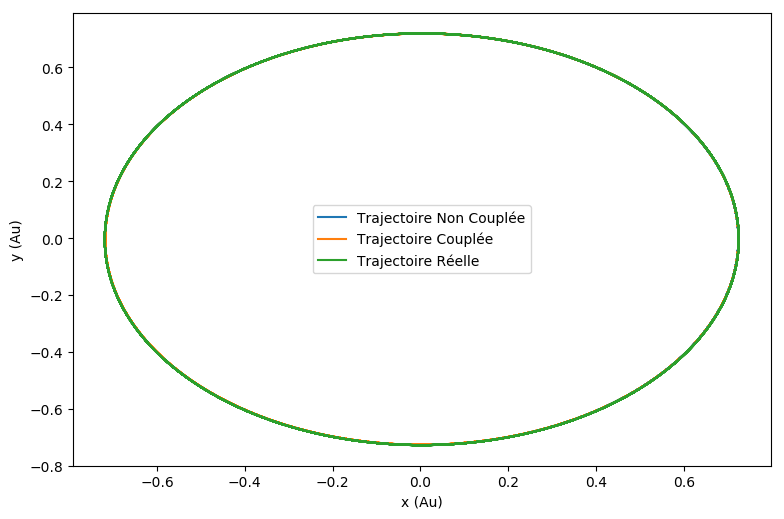

In [14]:
#Definition de figure
fig=plt.figure(figsize=(9, 6), dpi= 100, facecolor='w', edgecolor='k') #To modify the size of the figure
ax = fig.add_subplot(111) #definition de l'axe en 3d

#plt.gca().set_aspect('equal', adjustable='box') #equal ratios of x and y

ax.plot(bodies[2].x, bodies[2].y, label = "Trajectoire Non Couplée") #Cas sans couplage
ax.plot(bodies_[2].x, bodies_[2].y, label = "Trajectoire Couplée") #Cas couplage

#Import de la trajectoire de Jupyter
x, y = np.genfromtxt("real_simulation_venus.txt", usecols=(2,3), skip_header=1, unpack=True, delimiter=",") #Fichier dans le meme dossier En_3dim
ax.plot(x, y, label="Trajectoire Réelle") #Traj réelle

ax.set_xlabel("x (Au)")
ax.set_ylabel("y (Au)")
    
plt.legend()    
plt.show()

**Plot des trajectoires suivant y et z:**

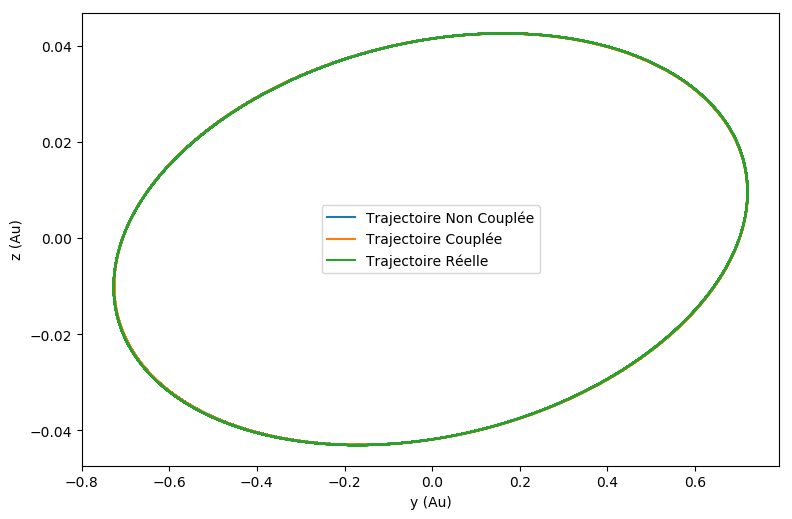

In [15]:
#Definition de figure
fig=plt.figure(figsize=(9, 6), dpi= 100, facecolor='w', edgecolor='k') #To modify the size of the figure
ax = fig.add_subplot(111) #definition de l'axe en 3d

#plt.gca().set_aspect('equal', adjustable='box') #equal ratios of x and y

ax.plot(bodies[2].y, bodies[2].z, label = "Trajectoire Non Couplée") #Cas sans couplage
ax.plot(bodies_[2].y, bodies_[2].z, label = "Trajectoire Couplée") #Cas couplage

#Import de la trajectoire de Jupyter
y, z = np.genfromtxt("real_simulation_venus.txt", usecols=(3,4), skip_header=1, unpack=True, delimiter=",") #Fichier dans le meme dossier In_3dim
ax.plot(y, z, label="Trajectoire Réelle") #Traj réelle

ax.set_xlabel("y (Au)")
ax.set_ylabel("z (Au)")

plt.legend()    
plt.show()

### 2.3.2 Terre:

**Plot des trajectoires suivant x et y:**

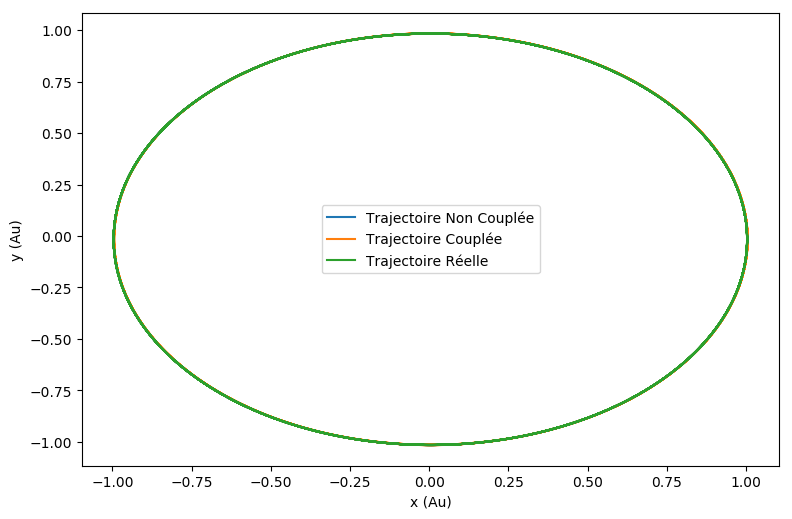

In [16]:
#Definition de figure
fig=plt.figure(figsize=(9, 6), dpi= 100, facecolor='w', edgecolor='k') #To modify the size of the figure
ax = fig.add_subplot(111) #definition de l'axe en 3d

#plt.gca().set_aspect('equal', adjustable='box') #equal ratios of x and y

ax.plot(bodies[3].x, bodies[3].y, label = "Trajectoire Non Couplée") #Cas sans couplage
ax.plot(bodies_[3].x, bodies_[3].y, label = "Trajectoire Couplée") #Cas couplage

#Import de la trajectoire de Jupyter
x, y = np.genfromtxt("real_simulation_earth.txt", usecols=(2,3), skip_header=1, unpack=True, delimiter=",") #Fichier dans le meme dossier In_3dim
ax.plot(x, y, label="Trajectoire Réelle") #Traj réelle

ax.set_xlabel("x (Au)")
ax.set_ylabel("y (Au)")
    
plt.legend()    
plt.show()

**Plot des trajectoires suivant y et z**:

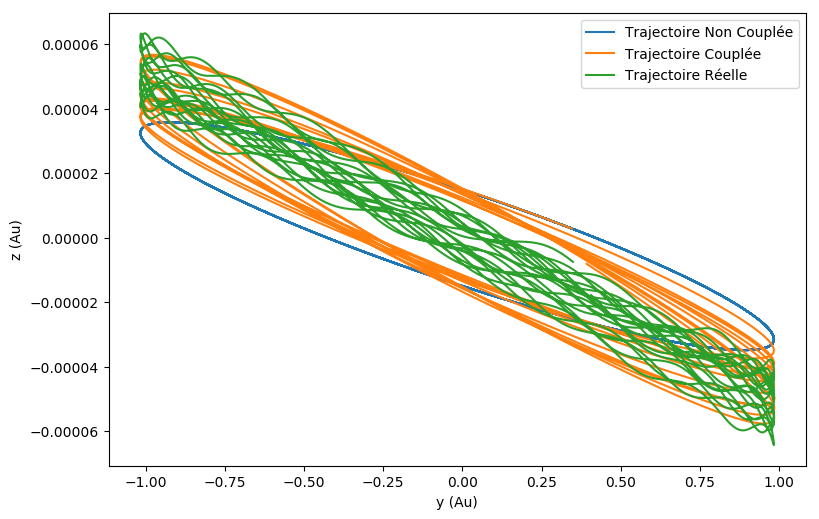

In [17]:
#Definition de figure
fig=plt.figure(figsize=(9, 6), dpi= 100, facecolor='w', edgecolor='k') #To modify the size of the figure
ax = fig.add_subplot(111) #definition de l'axe en 3d

#plt.gca().set_aspect('equal', adjustable='box') #equal ratios of x and y

ax.plot(bodies[3].y, bodies[3].z, label = "Trajectoire Non Couplée") #Cas sans couplage
ax.plot(bodies_[3].y, bodies_[3].z, label = "Trajectoire Couplée") #Cas couplage

#Import de la trajectoire de Jupyter
y, z = np.genfromtxt("real_simulation_earth.txt", usecols=(3,4), skip_header=1, unpack=True, delimiter=",") #Fichier dans le meme dossier In_3dim
ax.plot(y, z, label="Trajectoire Réelle") #Traj réelle

ax.set_xlabel("y (Au)")
ax.set_ylabel("z (Au)")

plt.legend()    
plt.show()

### 2.3.2 Jupyter: 

**Plot des trajectoires suivant x et y**:

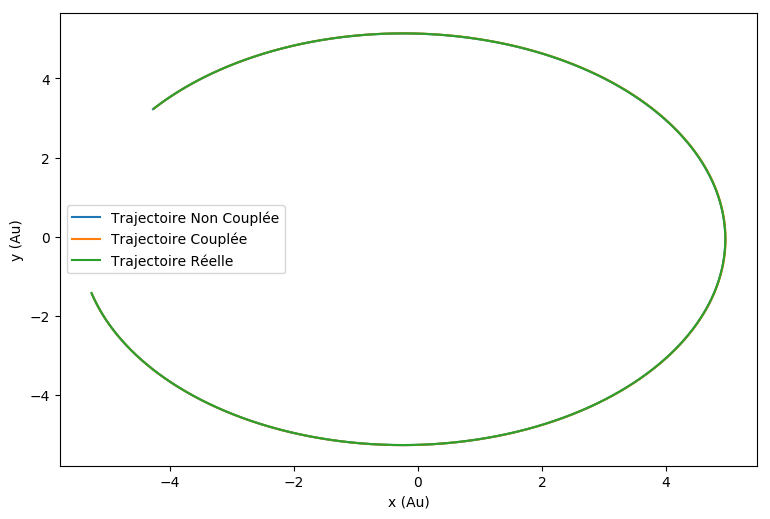

In [18]:
#Definition de figure

fig=plt.figure(figsize=(9, 6), dpi= 100, facecolor='w', edgecolor='k') #To modify the size of the figure
ax = fig.add_subplot(111) #definition de l'axe en 3d

#plt.gca().set_aspect('equal', adjustable='box') #equal ratios of x and y

ax.plot(bodies[5].x, bodies[5].y, label = "Trajectoire Non Couplée") #Cas sans couplage
ax.plot(bodies_[5].x, bodies_[5].y, label = "Trajectoire Couplée") #Cas couplage

#Import de la trajectoire de Jupyter
x, y = np.genfromtxt("real_simulation_jupyter.txt", usecols=(2,3), skip_header=1, unpack=True, delimiter=",") #Fichier dans le meme dossier In_3dim
ax.plot(x, y, label="Trajectoire Réelle") #Traj réelle

ax.set_xlabel("x (Au)")
ax.set_ylabel("y (Au)")
    
plt.legend()    
plt.show()

**Plot des trajectoires suivant y et z**:

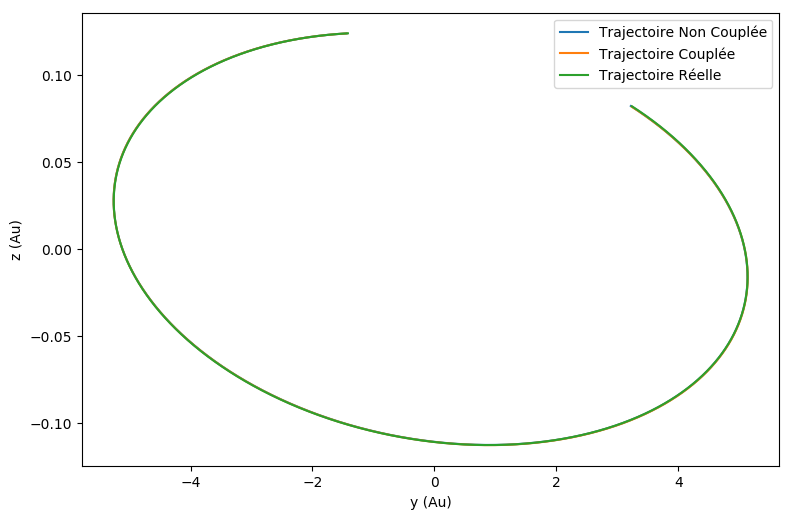

In [19]:
#Definition de figure
fig=plt.figure(figsize=(9, 6), dpi= 100, facecolor='w', edgecolor='k') #To modify the size of the figure
ax = fig.add_subplot(111) #definition de l'axe en 3d

#plt.gca().set_aspect('equal', adjustable='box') #equal ratios of x and y

ax.plot(bodies[5].y, bodies[5].z, label = "Trajectoire Non Couplée") #Cas sans couplage
ax.plot(bodies_[5].y, bodies_[5].z, label = "Trajectoire Couplée") #Cas couplage

#Import de la trajectoire de Jupyter
y, z = np.genfromtxt("real_simulation_jupyter.txt", usecols=(3,4), skip_header=1, unpack=True, delimiter=",") #Fichier dans le meme dossier In_3dim
ax.plot(y, z, label="Trajectoire Réelle") #Traj réelle

ax.set_xlabel("y (Au)")
ax.set_ylabel("z (Au)")

plt.legend()    
plt.show()

D'après les comparaisons entre les différentes trajectoires (on pourra aussi tester la précision des trajectoires pour les autres planètes), les trajectoires sans couplages reproduit bien les trajectoires réelles, alors on peut se limiter aux trajectoires sans couplage comme trajectoires de référence afin d'accélerer les calculs, cette approximation sera largement suffisante si on se limite à des durées d'integration relativement courtes à l'échelle astronomique comme la période de voyage d'une sonde interplanétaire, donc dans la troisième partie, on pourra travailler avec des trajectoires non couplées afin de déterminer la trajectoire des sondes spatiales.